In [13]:
# import packages

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from aero_design_functions import *
from scipy.optimize import fsolve
from lacbox.io import load_pwr, load_ind, load_inds, load_ae, load_pc, load_oper
from lacbox.test import test_data_path
from myteampack import MyHTC
from Our_values import *
from scipy.interpolate import interp1d

plt.rcParams.update({'font.family': 'serif', 'font.size':12})


In [14]:
# data

R = R_Y
r_hub = r_hub
R_X = R_X


scale = (R_Y - r_hub)/(R_X - r_hub)
r = np.linspace(r_hub, R_Y - 0.1, 40)  # Rotor span [m]

chord_root = 5.38  # Chord size at the root [m]
chord_max = 6.3

tsr = 7.2631578947368425
B = 3  # Number of blades [#]

Data_ae = load_ae("DTU_10MW_RWT_ae.dat")
data_ae = {
    'curve':Data_ae[:,0],
    'chord':Data_ae[:,1],
    'rel_th':Data_ae[:,2]
    }
abs_t=data_ae["chord"]*data_ae["rel_th"]/100*R_Y/R_X # new thickness
abs_t[0:2]=data_ae["chord"][0:2]
abs_t[2]=0.99*abs_t[2]
t = abs_t # Absolute thickness [m]


cl_des, cd_des, aoa_des, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions(2)

chord, tc, twist, cl, cd, aoa, a, CLT, CLP, CT, CP = single_point_design(
    r, t, tsr, R, cl_des, cd_des, aoa_des, chord_root, chord_max, B)

print(tc_vals)

[  0.   24.1  30.1  36.   48.  100. ]


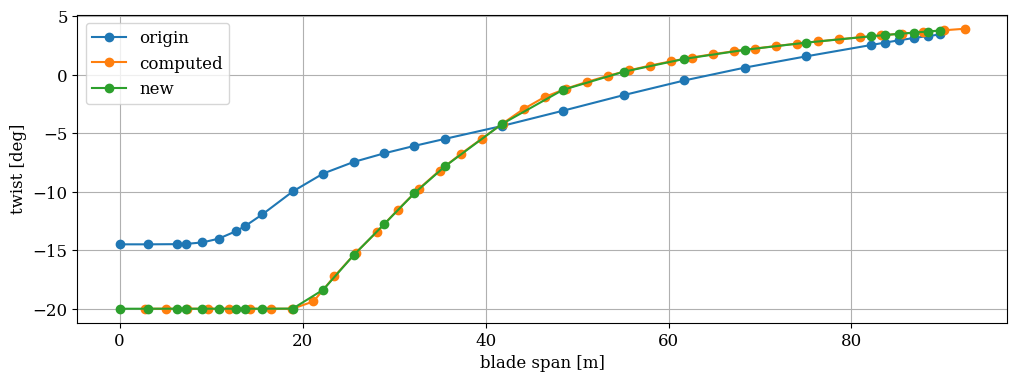

40


In [15]:
# to modify input hawc file, usefull printing statement


# modifations of _master/Group1_redesign.htc

original_z = np.array([4.44089E-16,
                    3.00000E+00,
                    6.00000E+00,
                    7.00004E+00,
                    8.70051E+00,
                    1.04020E+01,
                    1.22046E+01,
                    1.32065E+01,
                    1.50100E+01,
                    1.82151E+01,
                    2.14178E+01,
                    2.46189E+01,
                    2.78193E+01,
                    3.10194E+01,
                    3.42197E+01,
                    4.02204E+01,
                    4.66217E+01,
                    5.30232E+01,
                    5.94245E+01,
                    6.58255E+01,
                    7.22261E+01,
                    7.90266E+01,
                    8.05267E+01,
                    8.20271E+01,
                    8.35274E+01,
                    8.50277E+01,
                    8.63655E+01])

new_z = original_z*scale

#for element in new_z:
#    print(f"{element:.5E}")

original_twist = np.array([
    -1.45000E+01,
    -1.45000E+01,
    -1.44851E+01,
    -1.44610E+01,
    -1.43388E+01,
    -1.40201E+01,
    -1.33904E+01,
    -1.29371E+01,
    -1.19445E+01,
    -9.98243E+00,
    -8.45147E+00,
    -7.46417E+00,
    -6.72916E+00,
    -6.08842E+00,
    -5.49322E+00,
    -4.39222E+00,
    -3.09315E+00,
    -1.75629E+00,
    -5.00650E-01,
    6.01964E-01,
    1.55560E+00,
    2.51935E+00,
    2.72950E+00,
    2.93201E+00,
    3.11874E+00,
    3.28847E+00,
    3.42796E+00])

new_twist = -np.interp(new_z, r, twist)             # minus sign to be consistent with htc

plt.figure(figsize=(12,4))
plt.plot(new_z, original_twist, marker='o', label='origin')
plt.plot(r, -twist, marker='o', label='computed')
plt.plot(new_z, new_twist, marker='o', label='new')
plt.xlabel('blade span [m]')
plt.ylabel('twist [deg]')
plt.grid()
plt.legend()
plt.show()

#for element in new_twist:
#    print(f"{element:.5E}")


# modifications of data/DTU_10MW_RWT_ae.dat 
new_curve = r - r_hub

#for element in new_curve:
#    print(f"{element:.5E}")

#for element in chord:
#    print(f"{element:.5E}")

#for element in tc:
#    print(f"{element:.5E}")
print(len(tc))


In [16]:
# compute omega rated

V_rated_Y = 11.122788574520852
R_Y = 92.52423873190985
TSR_opt = 7.2631578947368425

omega_max = TSR_opt * V_rated_Y / R_Y * 60 / (2*np.pi)
print('omega_max', omega_max)

omega_max 8.337868262998404


RUN HAW2s 1ws 

dict_keys(['s_m', 'a', 'ap', 'flow_angle_rad', 'aoa_rad', 'flow_speed_ms', 'Fx_Nm', 'Fy_Nm', 'M_Nmm', 'UX0_m', 'UY0_m', 'UZ0_m', 'twist_rad', 'X_AC0_m', 'Y_AC0_m', 'Z_AC0_m', 'Cl', 'Cd', 'Cm', 'CLp0_rad', 'CDp0_rad', 'CMp0_rad', 'F0', 'F_rad', 'CL_FS0', 'CLFS_rad', 'V_a_ms', 'V_t_ms', 'torsion_rad', 'vx_ms', 'vy_ms', 'chord_m', 'CT', 'CP', 'angle_rad', 'v_1', 'v_2', 'v_3'])


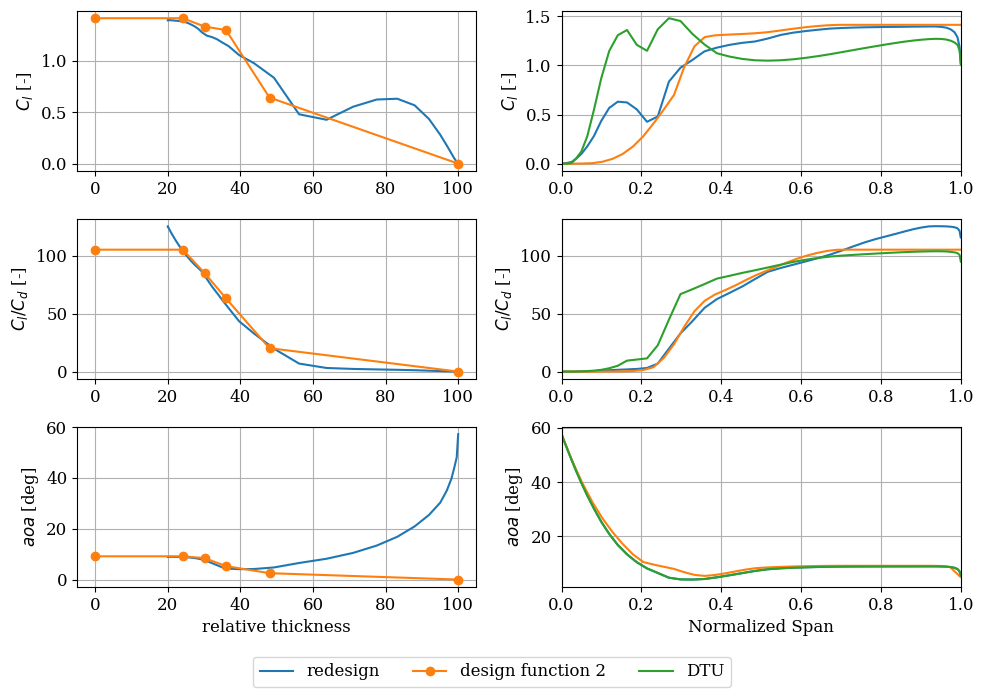

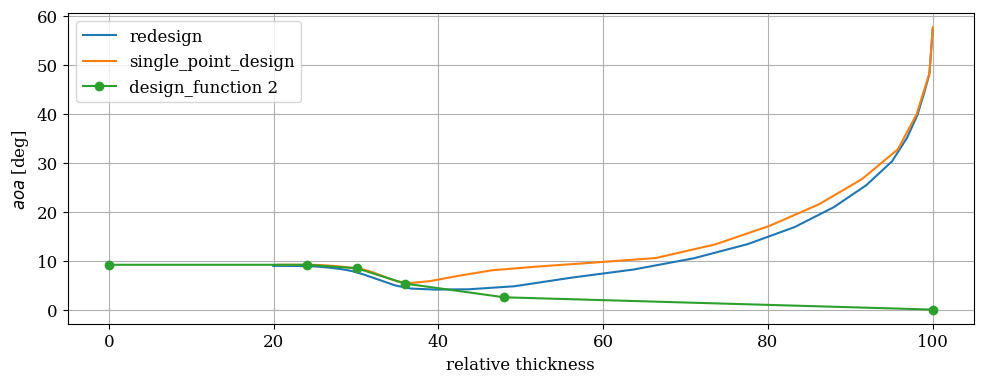

In [17]:
# open induction files
ind_data_path = 'hawc_files/our_design/res_hawc2s/Group1_redesign_hawc2s_1wsp_u11123.ind'
ind_data_DTU_10_path = 'hawc_files/dtu_10mw/res_hawc2s/dtu_10mw_hawc2s_1wsp_u8000.ind'

ind_data = load_ind(ind_data_path)
ind_data_DTU_10 = load_ind(ind_data_DTU_10_path)

# Print the names in the dict
print(ind_data.keys())

alpha_redesign = np.rad2deg(ind_data['aoa_rad'])
Cl_redesign = ind_data['Cl']
Cd_redesign = ind_data['Cd']
CP_redesign = ind_data['CP']
CT_redesign = ind_data['CT']
r_redesign = ind_data["s_m"]

alpha_DTU_10 = np.rad2deg(ind_data['aoa_rad'])
Cl_DTU_10 = ind_data_DTU_10['Cl']
Cd_DTU_10 = ind_data_DTU_10['Cd']
CP_DTU_10 = ind_data_DTU_10['CP']
CT_DTU_10 = ind_data_DTU_10['CT']
r_DTU_10 = ind_data_DTU_10["s_m"]

cl_des, cd_des, aoa_des, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions(2)
chord, tc, twist, cl, cd, aoa, a, CLT, CLP, CT, CP = single_point_design(
    r, t, tsr, R, cl_des, cd_des, aoa_des, chord_root, chord_max, B)

r_analytical = r - r_hub
Cl_analytical = cl
Cd_analytical = cd
alpha_analytical = aoa
a_analytical = a
CP_analytical = CLP
CT_analytical = CLT


r = np.linspace(r_hub, R_Y - 0.1, 40)  # Rotor span [m]
_, _, _, tc_vals, cl_vals1, cd_vals1, aoa_vals1 = get_design_functions(1)
_, _, _, tc_vals, cl_vals2, cd_vals2, aoa_vals2 = get_design_functions(2)
_, _, _, tc_vals, cl_vals3, cd_vals3, aoa_vals3 = get_design_functions(3)

r_analytical = r-r_hub
new_tc = np.interp(ind_data['s_m'], r_analytical, tc)

#plt.figure()
#plt.plot(ind_data['s_m'], Cl_redesign, label='HAWC2S')
#plt.plot(r_analytical, cl, label='computed')
#plt.legend()
#plt.figure()
#plt.plot(new_tc[:-4], ind_data['Cl'][:-4], label='HAWC2S')
#plt.plot(tc_vals, cl_vals, marker='o')
#plt.legend()


fig1, axs1 = plt.subplots(3, 2, num=1, figsize=(10,7), clear=True) 
axs1[0,0].plot(new_tc[:-6], Cl_redesign[:-6], label='redesign')
axs1[0,0].plot(tc_vals, cl_vals2, marker='o', label='design function 2')
axs1[0,0].set_ylabel("$C_l$ [-]")
axs1[0,0].grid(True)  # Add grid

axs1[0,1].plot(r_redesign/(R_Y-r_hub), Cl_redesign)
axs1[0,1].plot(r_analytical/(R_Y-r_hub), Cl_analytical)
axs1[0,1].plot(r_DTU_10/(R_X-r_hub), Cl_DTU_10, label='DTU')
axs1[0,1].set_ylabel("$C_l$ [-]")
axs1[0,1].set_xlim(0, 1)
axs1[0,1].grid(True)  # Add grid


axs1[1,0].plot(new_tc[:-6], Cl_redesign[:-6]/Cd_redesign[:-6])
axs1[1,0].plot(tc_vals, cl_vals2/cd_vals2, marker='o')
axs1[1,0].set_ylabel("$C_l/C_d$ [-]")
axs1[1,0].grid(True)  # Add grid

axs1[1,1].plot(r_redesign/(R_Y-r_hub), Cl_redesign/Cd_redesign)
axs1[1,1].plot(r_analytical/(R_Y-r_hub), Cl_analytical/Cd_analytical)
axs1[1,1].plot(r_DTU_10/(R_X-r_hub), Cl_DTU_10/Cd_DTU_10)
axs1[1,1].set_ylabel("$C_l/C_d$ [-]")
axs1[1,1].set_xlim(0, 1)
axs1[1,1].grid(True)  # Add grid


axs1[2,0].plot(new_tc[:-6], alpha_redesign[:-6])
#axs1[2,0].plot(tc, alpha_analytical)
axs1[2,0].plot(tc_vals, aoa_vals2, marker='o')
axs1[2,0].set_ylabel("$aoa$ [deg]")
axs1[2,0].set_xlabel("relative thickness")
axs1[2,0].grid(True)  # Add grid

axs1[2,1].plot(r_redesign/(R_Y-r_hub), alpha_redesign)
axs1[2,1].plot(r_analytical/(R_Y-r_hub), alpha_analytical)
axs1[2,1].plot(r_DTU_10/(R_X-r_hub), alpha_DTU_10)
axs1[2,1].set_ylabel("$aoa$ [deg]")
axs1[2,1].set_xlabel("Normalized Span") 
axs1[2,1].set_xlim(0, 1)
axs1[2,1].grid(True)  # Add grid

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Add more space at the bottom if needed
fig1.legend(loc='lower center', ncol=7, bbox_to_anchor=(0.5, -0.005))
plt.savefig('03_part1_all.pdf', format='pdf')
plt.show()


plt.figure(figsize=(10,4))
plt.plot(new_tc[:-6], alpha_redesign[:-6], label='redesign')
plt.plot(tc[:-5], alpha_analytical[:-5], label='single_point_design')
plt.plot(tc_vals, aoa_vals2, marker='o', label='design_function 2')
plt.ylabel("$aoa$ [deg]")
plt.xlabel("relative thickness")
plt.grid(True)  # Add grid
plt.legend()
plt.tight_layout()
plt.savefig('03_part1_addition.pdf', format='pdf')
plt.show()



In [18]:
'''

# open induction files
ind_data_path = 'hawc_files/our_design/res_hawc2s/Group1_redesign_hawc2s_1wsp_u11123.ind'
ind_data_DTU_10_path = 'hawc_files/dtu_10mw/res_hawc2s/dtu_10mw_hawc2s_1wsp_u8000.ind'

ind_data = load_ind(ind_data_path)
ind_data_DTU_10 = load_ind(ind_data_DTU_10_path)

# Print the names in the dict
#print(ind_data.keys())

alpha_redesign = np.rad2deg(ind_data['aoa_rad'])
Cl_redesign = ind_data['Cl']
Cd_redesign = ind_data['Cd']
CP_redesign = ind_data['CP']
CT_redesign = ind_data['CT']
r_redesign = ind_data["s_m"]

alpha_DTU_10 = np.rad2deg(ind_data['aoa_rad'])
Cl_DTU_10 = ind_data_DTU_10['Cl']
Cd_DTU_10 = ind_data_DTU_10['Cd']
CP_DTU_10 = ind_data_DTU_10['CP']
CT_DTU_10 = ind_data_DTU_10['CT']
r_DTU_10 = ind_data_DTU_10["s_m"]

# our data
r_analytical = r - r_hub
Cl_analytical = cl
Cd_analytical = cd
alpha_analytical = aoa
a_analytical = a
CP_analytical = CLP
CT_analytical = CLT

# Side-by-side plots of the HAWC2S lift coefficient and the design lift coefficient versus relative
# thickness (left plot) and versus radius (right plot) for design pitch and design TSR. The same should be
# done for the lift-drag ratio and AoA. Thus, curves plotted in section 2 are repeated in the plots for the
# relative thickness

# get tc to the number of nodes of HAWC2S files
cl_des, cd_des, aoa_des, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions(2)
chord, tc, twist, cl, cd, aoa, a, CLT, CLP, CT, CP = single_point_design(
    r, t, TSR_opt, R, cl_des, cd_des, aoa_des, chord_root, chord_max, B)

new_tc = np.interp(r_redesign, r_analytical, tc)
plt.figure(figsize=(12,4))
plt.plot(r_analytical, tc,  marker='o', label='computed')
plt.plot(r_redesign, new_tc,  marker='o', label='like htc')
plt.legend()
plt.show()


# Find the radius (r_redesign) that corresponds to each thickness (tc_points)
# sorted otherwise does not work
sorted_indices = np.argsort(new_tc)
sorted_new_tc = new_tc[sorted_indices]
sorted_r_redesign = r_redesign[sorted_indices]
r_points_redesign = np.interp(tc_vals, sorted_new_tc, sorted_r_redesign)
print('r', r_points_redesign)

plt.figure()
plt.title('radius at tc_vals')
plt.plot(r_redesign, new_tc)
for y in tc_vals:
    plt.axhline(y=y, color='r', linestyle='--', alpha=0.7)
plt.scatter(r_points_redesign, tc_vals)

# find Cl and alpha for the new radius corresponding to tc_vals
sorted_indices = np.argsort(r_redesign)
sorted_r_redesign = r_redesign[sorted_indices]
sorted_Cl_redesign = Cl_redesign[sorted_indices]
sorted_Cd_redesign = Cd_redesign[sorted_indices]
sorted_alpha_redesign = alpha_redesign[sorted_indices]
Cl_points_redesign = np.interp(r_points_redesign, sorted_r_redesign, sorted_Cl_redesign)
Cd_points_redesign = np.interp(r_points_redesign, sorted_r_redesign, sorted_Cd_redesign)
alpha_points_redesign = np.interp(r_points_redesign, sorted_r_redesign, sorted_alpha_redesign)


# get approximated data, just to check
tc_indexes = [30, 23, 19, 16]
tc_vals_approx = new_tc[tc_indexes]
r_points_redesign_approx = r_redesign[tc_indexes]
Cl_points_redesign_approx = Cl_redesign[tc_indexes]
alpha_points_redesign_approx = alpha_redesign[tc_indexes]

# data from part 2
Data_cl = load_pc("DTU_10MW_RWT_pc.dat") # return a list per blade
n = len(Data_cl)-2 # exclude airfoils of 100% and 60% relative thickness
des_param = np.zeros((4,n)) # relative thickness, cl design, cd design, AoA design
arg_0 = [63,63,63,58] # indices of the AoAs before stall

for k in range(n):
    cl_max = np.amax(Data_cl[k]["cl"][50:arg_0[k]])  # Maximum lift coefficient within the range
    cl_des = cl_max - 0.4

    # Finding corresponding AoA
    arg_max = np.where(Data_cl[k]["cl"] == cl_max)
    aoa_max = Data_cl[k]["aoa_deg"][arg_max]
    
    # Interpolating to find AoA and Cd of Cl design
    aoa_des = np.interp(cl_des, Data_cl[k]["cl"][50:arg_0[k]], Data_cl[k]["aoa_deg"][50:arg_0[k]])
    cd_des = np.interp(cl_des, Data_cl[k]["cl"][50:arg_0[k]], Data_cl[k]["cd"][50:arg_0[k]])
    des_param[:, k] = [Data_cl[k]["tc"], cl_des, cd_des, aoa_des]

cl_des1, cd_des1, aoa_des1, tc_vals1, cl_vals1, cd_vals1, aoa_vals1 = get_design_functions(1)
cl_des2, cd_des2, aoa_des2, tc_vals2, cl_vals2, cd_vals2, aoa_vals2 = get_design_functions(2)
cl_des3, cd_des3, aoa_des3, tc_vals3, cl_vals3, cd_vals3, aoa_vals3 = get_design_functions(3)

'''


'\n\n# open induction files\nind_data_path = \'hawc_files/our_design/res_hawc2s/Group1_redesign_hawc2s_1wsp_u11123.ind\'\nind_data_DTU_10_path = \'hawc_files/dtu_10mw/res_hawc2s/dtu_10mw_hawc2s_1wsp_u8000.ind\'\n\nind_data = load_ind(ind_data_path)\nind_data_DTU_10 = load_ind(ind_data_DTU_10_path)\n\n# Print the names in the dict\n#print(ind_data.keys())\n\nalpha_redesign = np.rad2deg(ind_data[\'aoa_rad\'])\nCl_redesign = ind_data[\'Cl\']\nCd_redesign = ind_data[\'Cd\']\nCP_redesign = ind_data[\'CP\']\nCT_redesign = ind_data[\'CT\']\nr_redesign = ind_data["s_m"]\n\nalpha_DTU_10 = np.rad2deg(ind_data[\'aoa_rad\'])\nCl_DTU_10 = ind_data_DTU_10[\'Cl\']\nCd_DTU_10 = ind_data_DTU_10[\'Cd\']\nCP_DTU_10 = ind_data_DTU_10[\'CP\']\nCT_DTU_10 = ind_data_DTU_10[\'CT\']\nr_DTU_10 = ind_data_DTU_10["s_m"]\n\n# our data\nr_analytical = r - r_hub\nCl_analytical = cl\nCd_analytical = cd\nalpha_analytical = aoa\na_analytical = a\nCP_analytical = CLP\nCT_analytical = CLT\n\n# Side-by-side plots of the H

In [19]:
'''

# additional plots

# Cl versis tc
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
#ax.plot(des_param[0,:], des_param[1,:], marker='o', label="computed")
ax.plot(tc_vals, cl_vals, marker='o', label="design function")
ax.plot(tc_vals, Cl_points_redesign, marker='o', label="HAWC2S file")
ax.plot(tc_vals_approx, Cl_points_redesign_approx, marker='o', label="HAWC2S file2")
ax.set_xlabel('${t/c}$ [%]')
ax.set_ylabel('$C_l$')
ax.legend()
ax.grid()

# alpha versus tc
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
#ax.plot(des_param[0,:], des_param[3,:], marker='o', label="computed")
ax.plot(tc_vals, aoa_vals, marker='o', label="design function")
ax.plot(tc_vals, alpha_points_redesign, marker='o', label="HAWC2S file")
ax.plot(tc_vals_approx, alpha_points_redesign_approx, marker='o', label="HAWC2S file2")
ax.set_xlabel('${t/c}$ [%]')
ax.set_ylabel('$aoa$')
ax.legend()
ax.grid()

'''

'\n\n# additional plots\n\n# Cl versis tc\nfig, ax = plt.subplots(1, 1, figsize=(8, 3))\n#ax.plot(des_param[0,:], des_param[1,:], marker=\'o\', label="computed")\nax.plot(tc_vals, cl_vals, marker=\'o\', label="design function")\nax.plot(tc_vals, Cl_points_redesign, marker=\'o\', label="HAWC2S file")\nax.plot(tc_vals_approx, Cl_points_redesign_approx, marker=\'o\', label="HAWC2S file2")\nax.set_xlabel(\'${t/c}$ [%]\')\nax.set_ylabel(\'$C_l$\')\nax.legend()\nax.grid()\n\n# alpha versus tc\nfig, ax = plt.subplots(1, 1, figsize=(8, 3))\n#ax.plot(des_param[0,:], des_param[3,:], marker=\'o\', label="computed")\nax.plot(tc_vals, aoa_vals, marker=\'o\', label="design function")\nax.plot(tc_vals, alpha_points_redesign, marker=\'o\', label="HAWC2S file")\nax.plot(tc_vals_approx, alpha_points_redesign_approx, marker=\'o\', label="HAWC2S file2")\nax.set_xlabel(\'${t/c}$ [%]\')\nax.set_ylabel(\'$aoa$\')\nax.legend()\nax.grid()\n\n'

In [20]:
'''

plt.rcParams.update({'font.family': 'serif', 'font.size':14})

# Plot Cl
fig1, axs1 = plt.subplots(1, 2, figsize=(12, 6), num=1, clear=True)  # Adjust figure size for better spacing
axs1[0].plot(new_tc, Cl_DTU_10, label='DTU 10 MW', linewidth=2)
axs1[0].plot(new_tc, Cl_redesign, label='Redesigned', linewidth=2)
axs1[0].plot(tc, Cl_analytical, label='computed', linewidth=2)
#axs1[0].plot(tc_vals1, cl_vals1, marker='o', label="design function 1")
axs1[0].plot(tc_vals, cl_vals2, marker='o', label="design function 2", linewidth=2)
#axs1[0].plot(tc_vals3, cl_vals3, marker='o', label="design function 3")
#axs1[0].plot(tc_vals, Cl_points_redesign, marker='o', label="HAWC2S file")
axs1[0].set_ylabel("$C_l$ [-]")
#axs1[0].set_xlim(0, 100)
axs1[0].set_xlim(21, 50)
axs1[0].set_ylim(0.4, 1.5)
axs1[0].set_xlabel("relative thickness")
axs1[0].grid(True)  # Add grid

axs1[1].plot(r_DTU_10/(R_X-r_hub), Cl_DTU_10, linewidth=2)
axs1[1].plot(r_redesign/(R_Y-r_hub), Cl_redesign, linewidth=2)
axs1[1].plot(r_analytical/(R_Y-r_hub), Cl_analytical, linewidth=2)
axs1[1].set_ylabel("$C_l$ [-]")
axs1[1].set_xlabel("Normalized Span") 
axs1[1].set_xlim(0, 1)
axs1[1].grid(True)  # Add grid
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Add more space at the bottom if needed
fig1.legend(loc='lower center', ncol=7, bbox_to_anchor=(0.5, -0.005))
plt.savefig('03_part1_Cl.pdf', format='pdf')
plt.show()


# Plot Cl/Cd
fig2, axs2 = plt.subplots(1, 2, figsize=(12, 6), num=1, clear=True)
axs2[0].plot(new_tc, Cl_DTU_10/Cd_DTU_10, label='DTU 10 MW', linewidth=2)
axs2[0].plot(new_tc, Cl_redesign/Cd_redesign, label='Redesigned', linewidth=2)
axs2[0].plot(tc, Cl_analytical/Cd_analytical, label='computed', linewidth=2)
#axs2[0].plot(tc_vals1, cl_vals1/cd_vals1, marker='o', label="design function 1")
axs2[0].plot(tc_vals, cl_vals2/cd_vals2, marker='o', label="design function 2", linewidth=2)
#axs2[0].plot(tc_vals3, cl_vals3/cd_vals3, marker='o', label="design function 3")
axs2[0].set_ylabel("$C_l/C_d$ [-]")
#axs2[0].set_xlim(0, 100)
axs2[0].set_xlim(21, 50)
axs2[0].set_xlabel("relative thickness")
axs2[0].grid(True)  # Add grid

axs2[1].plot(r_DTU_10/(R_X-r_hub), Cl_DTU_10/Cd_DTU_10, linewidth=2)
axs2[1].plot(r_redesign/(R_Y-r_hub), Cl_redesign/Cd_redesign, linewidth=2)
axs2[1].plot(r_analytical/(R_Y-r_hub), Cl_analytical/Cd_analytical, linewidth=2)
axs2[1].set_ylabel("$C_l/C_d$ [-]")
axs2[1].set_xlabel("Normalized Span") 
axs2[1].set_xlim(0, 1)
axs2[1].grid(True)  # Add grid
plt.tight_layout()
fig2.legend(loc='lower center', ncol=7, bbox_to_anchor=(0.5, -0.05))
plt.savefig('03_part1_Cl_Cd.pdf', format='pdf', bbox_inches='tight')
plt.show()


# Plot alpha
fig3, axs3 = plt.subplots(1, 2, figsize=(12, 6), num=1, clear=True)
axs3[0].plot(new_tc, alpha_DTU_10, label='DTU 10 MW', linewidth=2)
axs3[0].plot(new_tc, alpha_redesign, label='Redesigned', linewidth=2)
axs3[0].plot(tc, alpha_analytical, label='computed', linewidth=2)
axs3[0].plot(tc_vals, aoa_vals2, marker='o', label="design function 2", linewidth=2)
#axs3[0].plot(tc_vals_approx, alpha_points_redesign_approx, marker='o', label="design function 2")
axs3[0].set_ylabel("$aoa$ [-]")
#axs3[0].set_xlim(21, 50)
#axs3[0].set_ylim(0, 12)
axs3[0].set_xlabel("relative thickness")
axs3[0].grid(True)  # Add grid

axs3[1].plot(r_DTU_10/(R_X-r_hub), alpha_DTU_10, linewidth=2)
axs3[1].plot(r_redesign/(R_Y-r_hub), alpha_redesign, linewidth=2)
axs3[1].plot(r_analytical/(R_Y-r_hub), alpha_analytical, linewidth=2)
axs3[1].set_ylabel("$aoa$ [-]")
axs3[1].set_xlabel("Normalized Span") 
axs3[1].set_xlim(0, 1)
axs3[1].grid(True)  # Add grid
plt.tight_layout()
fig3.legend(loc='lower center', ncol=7, bbox_to_anchor=(0.5, -0.001))
plt.subplots_adjust(bottom=0.2)  # Add more space at the bottom if needed
plt.savefig('03_part1_alpha.pdf', format='pdf')
plt.show()

'''

'\n\nplt.rcParams.update({\'font.family\': \'serif\', \'font.size\':14})\n\n# Plot Cl\nfig1, axs1 = plt.subplots(1, 2, figsize=(12, 6), num=1, clear=True)  # Adjust figure size for better spacing\naxs1[0].plot(new_tc, Cl_DTU_10, label=\'DTU 10 MW\', linewidth=2)\naxs1[0].plot(new_tc, Cl_redesign, label=\'Redesigned\', linewidth=2)\naxs1[0].plot(tc, Cl_analytical, label=\'computed\', linewidth=2)\n#axs1[0].plot(tc_vals1, cl_vals1, marker=\'o\', label="design function 1")\naxs1[0].plot(tc_vals, cl_vals2, marker=\'o\', label="design function 2", linewidth=2)\n#axs1[0].plot(tc_vals3, cl_vals3, marker=\'o\', label="design function 3")\n#axs1[0].plot(tc_vals, Cl_points_redesign, marker=\'o\', label="HAWC2S file")\naxs1[0].set_ylabel("$C_l$ [-]")\n#axs1[0].set_xlim(0, 100)\naxs1[0].set_xlim(21, 50)\naxs1[0].set_ylim(0.4, 1.5)\naxs1[0].set_xlabel("relative thickness")\naxs1[0].grid(True)  # Add grid\n\naxs1[1].plot(r_DTU_10/(R_X-r_hub), Cl_DTU_10, linewidth=2)\naxs1[1].plot(r_redesign/(R_Y-r_h

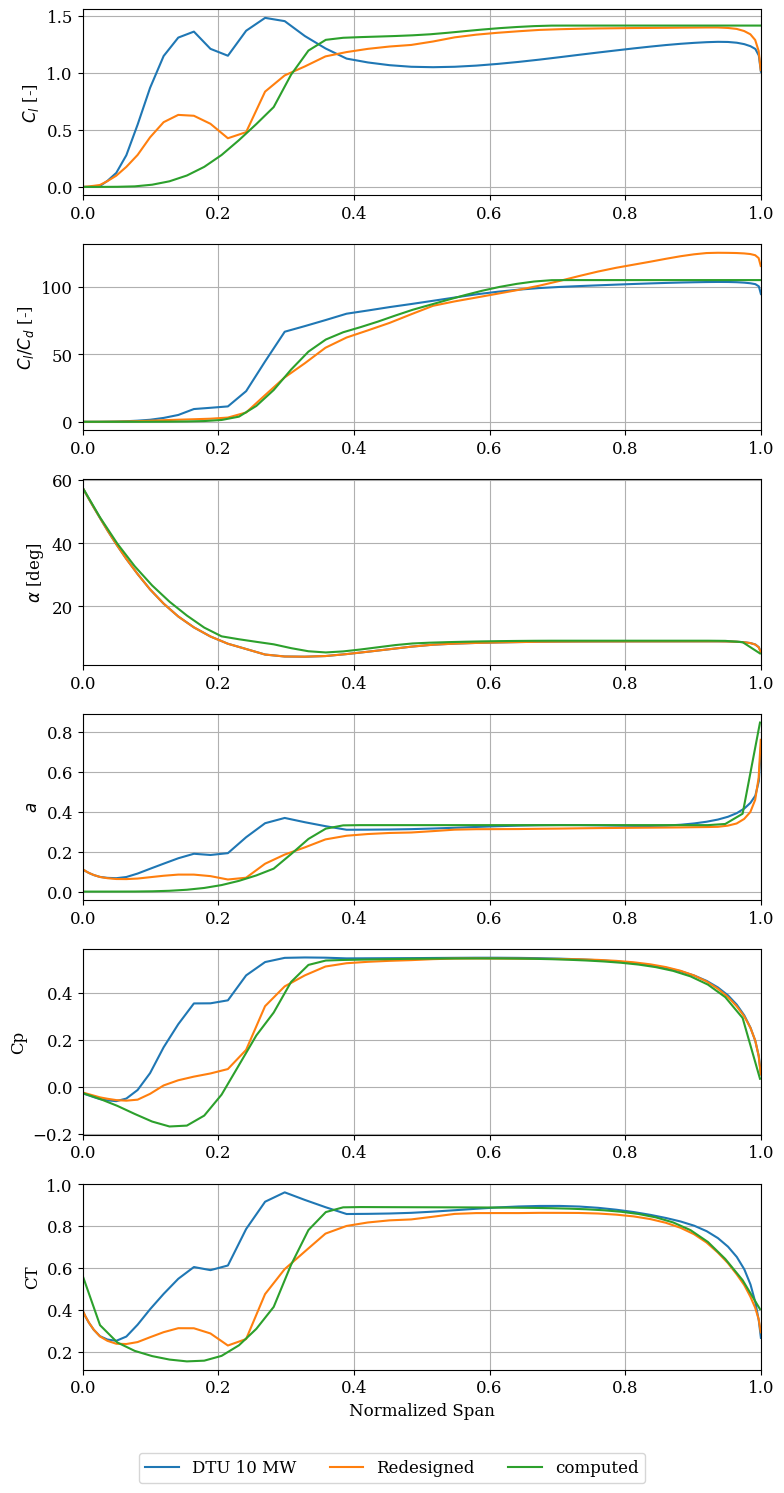

In [21]:
# quantities as a function of radius, looks good

# Create subplots with increased vertical spacing
fig1, axs1 = plt.subplots(6, 1, num=1, clear=True, figsize=(8, 15))  # Adjust figure size for better spacing
fig1.subplots_adjust(hspace=0.4)  # Increase the space between the plots

# Plot Cl
axs1[0].plot(r_DTU_10/(R_X-r_hub), Cl_DTU_10, label='DTU 10 MW')
axs1[0].plot(r_redesign/(R_Y-r_hub), Cl_redesign, label='Redesigned')
axs1[0].plot(r_analytical/(R_Y-r_hub), Cl_analytical, label='computed')
axs1[0].set_ylabel("$C_l$ [-]")
axs1[0].set_xlim(0, 1)
axs1[0].grid(True)  # Add grid

# Plot Cl / Cd
axs1[1].plot(r_DTU_10/(R_X-r_hub), (Cl_DTU_10 / Cd_DTU_10))
axs1[1].plot(r_redesign/(R_Y-r_hub), (Cl_redesign / Cd_redesign))
axs1[1].plot(r_analytical/(R_Y-r_hub), (Cl_analytical/Cd_analytical))
axs1[1].set_ylabel("$C_l / C_d$ [-]")
axs1[1].set_xlim(0, 1)
axs1[1].grid(True)  # Add grid

# Plot AoA with label
axs1[2].plot(r_DTU_10/(R_X-r_hub), alpha_DTU_10)
axs1[2].plot(r_redesign/(R_Y-r_hub), alpha_redesign)
axs1[2].plot(r_analytical/(R_Y-r_hub), alpha_analytical)
axs1[2].set_ylabel(r"$\alpha$ [deg]")
axs1[2].set_xlim(0, 1)
axs1[2].grid(True)  # Add grid


axs1[3].plot(r_DTU_10/(R_X-r_hub), ind_data_DTU_10["a"])
axs1[3].plot(r_redesign/(R_Y-r_hub), ind_data["a"])
axs1[3].plot(r_analytical/(R_Y-r_hub), a_analytical)
axs1[3].set_ylabel(r"$a$")
axs1[3].set_xlim(0, 1)
axs1[3].grid(True)  # Add grid

axs1[4].plot(r_DTU_10/(R_X-r_hub), ind_data_DTU_10["CP"])
axs1[4].plot(r_redesign/(R_Y-r_hub), ind_data["CP"])
axs1[4].plot(r_analytical/(R_Y-r_hub), CP_analytical)
axs1[4].set_ylabel('Cp')
axs1[4].set_xlim(0, 1)
axs1[4].grid(True)  # Add grid

axs1[5].plot(r_DTU_10/(R_X-r_hub), ind_data_DTU_10["CT"])
axs1[5].plot(r_redesign/(R_Y-r_hub), ind_data["CT"])
axs1[5].plot(r_analytical/(R_Y-r_hub), CT_analytical)
axs1[5].set_ylabel('CT')
axs1[5].set_xlabel("Normalized Span")  # Add label for the last plot
axs1[5].set_xlim(0, 1)
axs1[5].grid(True)  # Add grid

plt.tight_layout()
fig1.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.001))
plt.subplots_adjust(bottom=0.08)  # Add more space at the bottom if needed
plt.savefig('03_part2_quantities_vs_radius.pdf', format='pdf')
plt.show()

RUN HAW2s multiws (actually multy TSR, constant speed and changing omega)

In [22]:
# compute omega for redesign
# V_rated_Y = 11.12278

TSR_range = np.arange(5.5,10.5,0.2)
print('number of lines', len(TSR_range))

V_rated_Y_range = np.arange(V_rated_Y, V_rated_Y + len(TSR_range) * 0.001 - 0.001, 0.001)

omega_range = TSR_range * V_rated_Y_range / R_Y * 60 / (2*np.pi)

#for element in V_rated_Y_range:
#    print(f"{element:.6f}")

#for element in omega_range:
#    print(f"{element:.6f}")


# for pmega for DTU 10 MW
V_rated_X_range = np.arange(V_rated_X, V_rated_X + len(TSR_range) * 0.001 - 0.001, 0.001)
omega_range_X = TSR_range * V_rated_X_range/ R_X * 60 / (2*np.pi)

#for element in V_rated_X_range:
#    print(f"{element:.6f}")

for element in omega_range_X:
    print(f"{element:.6f}")

number of lines 25
6.715353
6.960158
7.205006
7.449897
7.694831
7.939807
8.184827
8.429889
8.674994
8.920142
9.165333
9.410566
9.655843
9.901162
10.146524
10.391929
10.637377
10.882867
11.128401
11.373977
11.619596
11.865258
12.110963
12.356711
12.602501


DTU: max CP = 0.483 at TSR = 8.300
redesign: max CP = 0.457 at TSR = 7.500
redesign percentual difference with computed: max CP = , max TSR = 3.261%
anal: max CP = 0.441 at TSR = 7.100


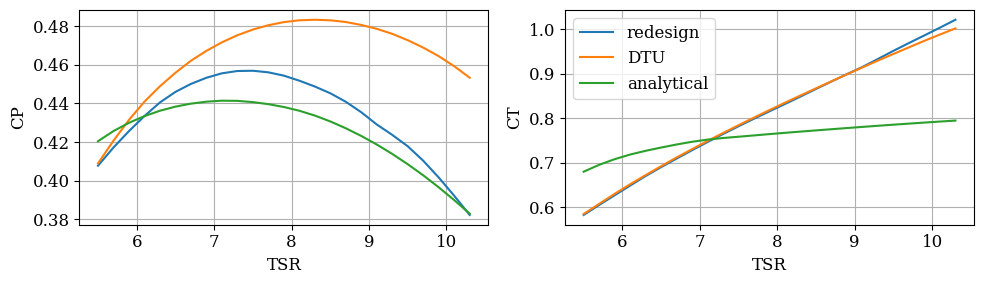

In [23]:
# Side-by-side plots of the power and thrust coefficients calculated with HAWC2S at design pitch versus TSR

pwr_path = "hawc_files/our_design/res_hawc2s/Group1_redesign_hawc2s_multiwsp.pwr"
pwr_data = load_pwr(pwr_path)

pwr_path_DTU_10_MW = "hawc_files/dtu_10mw/res_hawc2s/dtu_10mw_hawc2s_multiwsp.pwr"
pwr_data_DTU_10_MW = load_pwr(pwr_path_DTU_10_MW)


CP_list = []
CT_list = []
cl_des, cd_des, aoa_des, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions(2)

for tsr in TSR_range:
    # %% Solving for the a single design
    chord, tc, twist, cl, cd, aoa, a, CLT, CLP, CT, CP = single_point_design(
        r, t, tsr, R, cl_des, cd_des, aoa_des, chord_root, chord_max, B)
    CP_list.append(CP)
    CT_list.append(CT)

CP_array = np.array(CP_list)
CT_array = np.array(CT_list)


# find max

CP_max_DTU = np.amax(pwr_data_DTU_10_MW["Cp"])
TSR_max_DTU = TSR_range[np.argmax(pwr_data_DTU_10_MW["Cp"])]
CP_max_redesign = np.amax(pwr_data["Cp"])
TSR_max_redesign = TSR_range[np.argmax(pwr_data["Cp"])]
CP_max_anal = np.amax(CP_array)
TSR_max_anal = TSR_range[np.argmax(CP_array)]

print(f'DTU: max CP = {CP_max_DTU:.3f} at TSR = {TSR_max_DTU:.3f}')
print(f'redesign: max CP = {CP_max_redesign:.3f} at TSR = {TSR_max_redesign:.3f}')
print(f'redesign percentual difference with computed: max CP = , max TSR = {(TSR_max_redesign - TSR_opt)/TSR_opt*100:.3f}%')
print(f'anal: max CP = {CP_max_anal:.3f} at TSR = {TSR_max_anal:.3f}')




fig1, axs1 = plt.subplots(1, 2, num=2, figsize=(10,3), clear=True)
axs1[0].plot(TSR_range, pwr_data["Cp"])
axs1[0].plot(TSR_range, pwr_data_DTU_10_MW["Cp"])
axs1[0].plot(TSR_range, CP_array)
axs1[0].set_xlabel("TSR")
axs1[0].set_ylabel("CP")
axs1[0].grid(True)
#axs1[0].set_xlim(min(TSR_range), max(TSR_range))

axs1[1].plot(TSR_range, pwr_data["Ct"],  label='redesign')
axs1[1].plot(TSR_range, pwr_data_DTU_10_MW["Ct"], label='DTU')
axs1[1].plot(TSR_range, CT_array, label='analytical')
axs1[1].set_xlabel("TSR")
axs1[1].set_ylabel("CT")
axs1[1].legend()
axs1[1].grid(True)
#axs1[1].set_xlim(min(TSR_range), max(TSR_range))

# Adjust layout and show the figure
plt.tight_layout()
#fig1.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.005))
#plt.savefig('CP_CT_multiple', dpi=600)
#plt.subplots_adjust(bottom=0.2)
plt.savefig('03_part3_CP_CT_multiple.pdf', format='pdf')
plt.show()


[ 1.30730545  1.30730251  1.30730246  1.30730249  1.30730249  1.30730247
  1.30730248  1.30730248  1.29687188  1.12521182  0.22871816  0.00945086
 -0.01136976 -0.00587382  0.01496982  0.01880559 -0.01553484  0.02988911
  0.00147757 -0.01257297  0.01977373 -0.00705586 -0.06558076 -0.01480117
  0.02276128  0.03689027  0.00448976  0.3975924   0.05340684  0.06211119
  0.00430197]


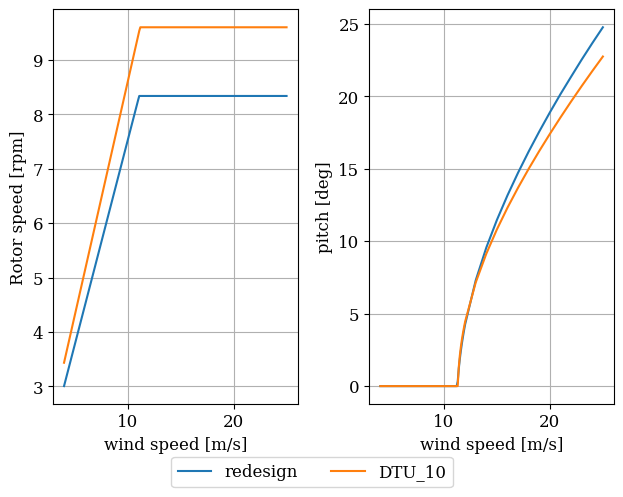

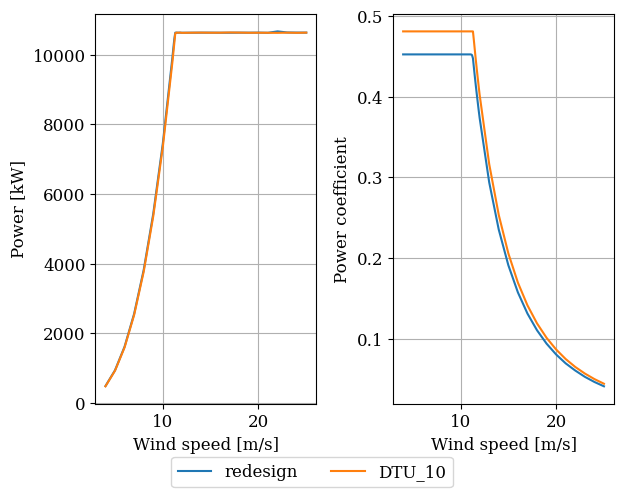

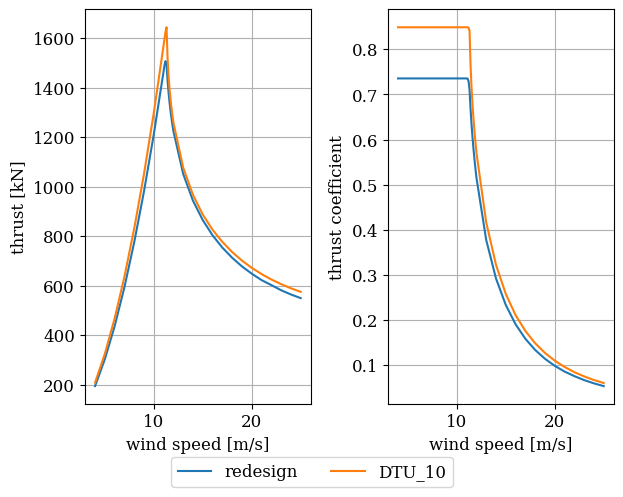

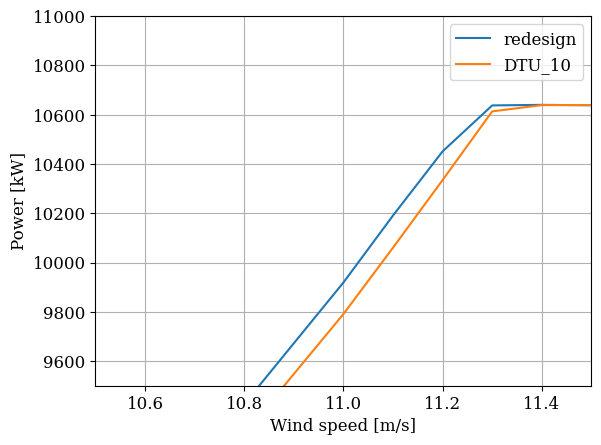

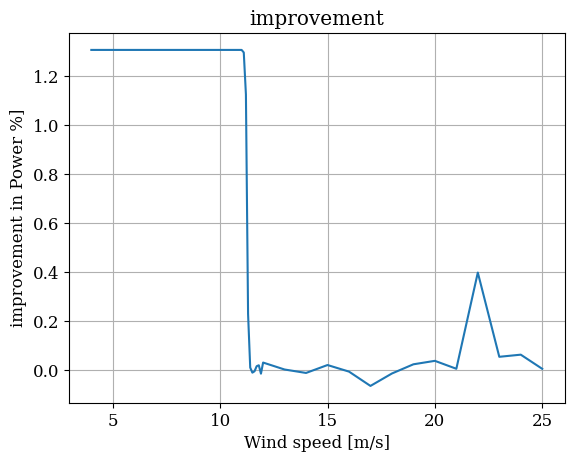

In [24]:
# Side-by-side plots of the rotor speed (left plot) and pitch angles (right plot) versus wind speed

# extract data from HAWC result
rigid_path = "hawc_files/our_design/data/Group1_redesign_rigid.opt"
rigid_data = load_oper(rigid_path)
rigid_DTU_10_path = "hawc_files/our_design/data/dtu_10mw_rigid.opt"
rigid_DTU_10_data = load_oper(rigid_DTU_10_path)
#print(rigid_data.keys())

# power improvement
imp = (rigid_data['power_kw'] - rigid_DTU_10_data['power_kw']) / rigid_DTU_10_data['power_kw']*100
print(imp)




# plot rotor speed and pitch
fig1, axs1 = plt.subplots(1, 2, num=2, clear=True)

axs1[0].plot(rigid_data['ws_ms'], rigid_data['rotor_speed_rpm'], label='redesign')
axs1[0].plot(rigid_DTU_10_data['ws_ms'], rigid_DTU_10_data['rotor_speed_rpm'], label='DTU_10')
axs1[0].set_xlabel("wind speed [m/s]")
axs1[0].set_ylabel("Rotor speed [rpm]")
axs1[0].grid(True)

axs1[1].plot(rigid_data['ws_ms'], rigid_data['pitch_deg'])
axs1[1].plot(rigid_DTU_10_data['ws_ms'], rigid_DTU_10_data['pitch_deg'])
axs1[1].set_xlabel("wind speed [m/s]")
axs1[1].set_ylabel("pitch [deg]")
axs1[1].grid(True)

plt.tight_layout()
fig1.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))
plt.savefig('03_part4_rotor_pitch.pdf', format='pdf')
plt.show()


# Side-by-side plots of the aerodynamic power (left plot) and its coefficient (right plot), and the thrust (left plot) and its coefficient (right plot) versus wind speed
rho = 1.225
CP_redesign = rigid_data['power_kw'] / (0.5 * rho * rigid_data['ws_ms']**3 * np.pi*R_Y**2)*1e3
CP_DTU_10 = rigid_DTU_10_data['power_kw'] / (0.5 * rho * rigid_DTU_10_data['ws_ms']**3 * np.pi*R_X**2)*1e3

CT_redesign = rigid_data['thrust_kn'] / (0.5 * rho * rigid_data['ws_ms']**2 * np.pi*R_Y**2)*1e3
CT_DTU_10 = rigid_DTU_10_data['thrust_kn'] / (0.5 * rho * rigid_DTU_10_data['ws_ms']**2 * np.pi*R_X**2)*1e3



# power
fig1, axs1 = plt.subplots(1, 2, num=2, clear=True)
axs1[0].plot(rigid_data['ws_ms'], rigid_data['power_kw'], label='redesign')
axs1[0].plot(rigid_DTU_10_data['ws_ms'], rigid_DTU_10_data['power_kw'], label='DTU_10')
axs1[0].set_ylabel("Power [kW]")
axs1[0].set_xlabel("Wind speed [m/s]")
axs1[0].grid(True)

axs1[1].plot(rigid_data['ws_ms'], CP_redesign)
axs1[1].plot(rigid_DTU_10_data['ws_ms'], CP_DTU_10)
axs1[1].set_ylabel("Power coefficient")
axs1[1].set_xlabel("Wind speed [m/s]")
axs1[1].grid(True)
plt.tight_layout()
fig1.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))
plt.savefig('03_part5_power.pdf', format='pdf')
plt.show()



# thrust
fig1, axs1 = plt.subplots(1, 2, num=2, clear=True)
axs1[0].plot(rigid_data['ws_ms'], rigid_data['thrust_kn'], label='redesign')
axs1[0].plot(rigid_DTU_10_data['ws_ms'], rigid_DTU_10_data['thrust_kn'], label='DTU_10')
axs1[0].set_xlabel("wind speed [m/s]")
axs1[0].set_ylabel("thrust [kN]")
axs1[0].grid(True)

axs1[1].plot(rigid_data['ws_ms'], CT_redesign)
axs1[1].plot(rigid_DTU_10_data['ws_ms'], CT_DTU_10)
axs1[1].set_xlabel("wind speed [m/s]")
axs1[1].set_ylabel("thrust coefficient")
axs1[1].grid(True)
plt.tight_layout()
fig1.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))
plt.savefig('03_part5_thrust.pdf', format='pdf')
plt.show()

plt.figure()
plt.plot(rigid_data['ws_ms'], rigid_data['power_kw'], label='redesign')
plt.plot(rigid_DTU_10_data['ws_ms'], rigid_DTU_10_data['power_kw'], label='DTU_10')
plt.ylabel("Power [kW]")
plt.xlabel("Wind speed [m/s]")
plt.legend()
plt.grid(True)
plt.xlim(10.5,11.5)
plt.ylim(9500,11000)
plt.show()


plt.figure()
plt.title('improvement')
plt.plot(rigid_data['ws_ms'], imp)
plt.ylabel("improvement in Power %]")
plt.xlabel("Wind speed [m/s]")
plt.grid(True)
plt.show()


# [ 1.30730545  1.30730251  1.30730246  1.30730249  1.30730249  1.30730247
#  1.30730248  1.30730248  1.29687188  1.12521182  0.22871816  0.00945086
# -0.01136976 -0.00587382  0.01496982  0.01880559 -0.01553484  0.02988911
#  0.00147757 -0.01257297  0.01977373 -0.00705586 -0.06558076 -0.01480117
#  0.02276128  0.03689027  0.00448976  0.3975924   0.05340684  0.06211119
#  0.00430197]